In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [5]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 207ms/step - loss: 0.2899 - root_mean_squared_error: 0.5384 - val_loss: 0.1261 - val_root_mean_squared_error: 0.3551
Epoch 2/50
53/53 [==============================] - 10s 197ms/step - loss: 0.1521 - root_mean_squared_error: 0.3900 - val_loss: 0.0362 - val_root_mean_squared_error: 0.1903
Epoch 3/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0585 - root_mean_squared_error: 0.2419 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1818
Epoch 4/50
53/53 [==============================] - 11s 204ms/step - loss: 0.0520 - root_mean_squared_error: 0.2280 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1764
Epoch 5/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0476 - root_mean_squared_error: 0.2181 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1788
Epoch 6/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0462 - root_mean_squared_error: 0.2149 - val_loss: 0.0327 - va

53/53 [==============================] - 2s 30ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350
Epoch 39/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0147 - root_mean_squared_error: 0.1212 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1447
Epoch 40/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 41/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0144 - root_mean_squared_error: 0.1201 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1357
Epoch 42/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0134 - root_mean_squared_error: 0.1156 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1282
Epoch 43/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159 - val_loss: 0.0167 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.1689521352450054 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

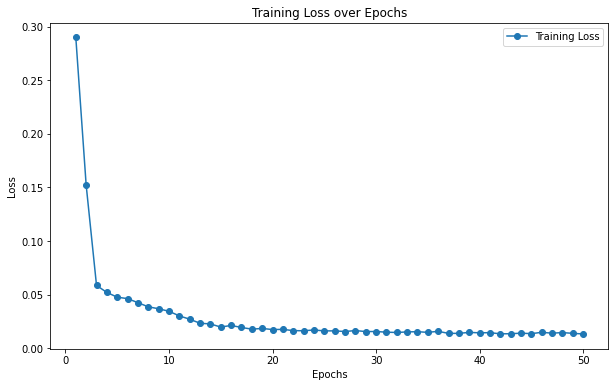

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

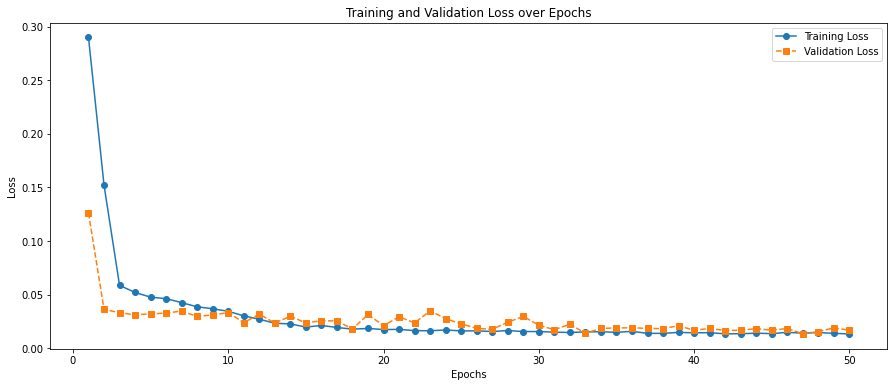

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 17ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.10036958081735141
MAE : 0.07579422501379705


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,655347.25000,584830.109
1,697745.81250,641562.292
2,714639.37500,734946.437
3,706198.62500,777596.225
4,661866.62500,687087.673
5,576528.37500,622337.816
6,486013.18750,467232.074
7,413810.84375,297495.641
8,386764.50000,268909.854
9,412885.37500,408072.791


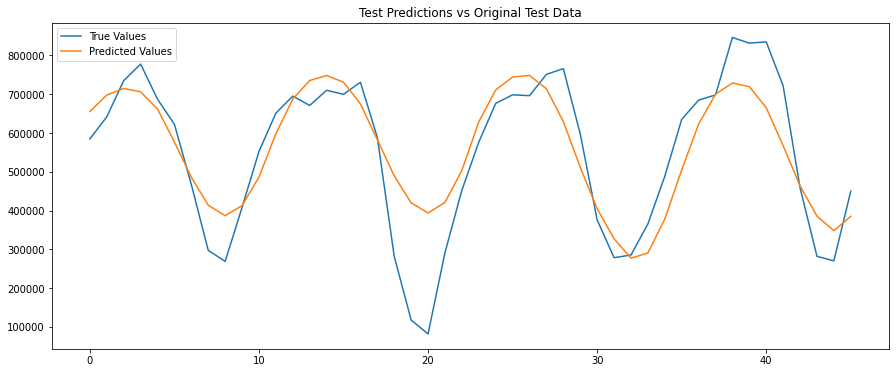

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 14ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

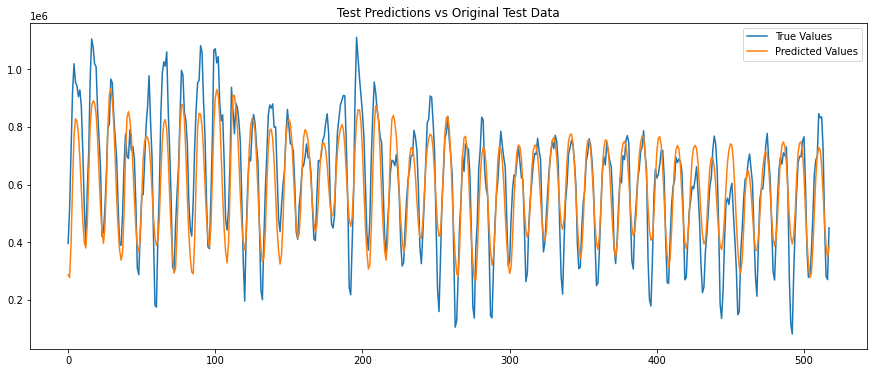

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()